## Import modules

In [1]:
from models.model_v2 import *
from data.midi_preprocessing import *
from utils.dataset_loader import *
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from IPython import display

/usr/lib/python3.13/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Loss tracker and intermediate results callback

In [2]:
# Callback to track the loss of the minmax game.
class LossTracker(L.Callback):
    def __init__(self, intermediate_samples=None, latent_dim=100):
        self.g_losses = []
        self.d_losses = []
        self.acc_real = []
        self.acc_fake = []

        self.grad_norm = []

        self.intermediate_samples = intermediate_samples
        if self.intermediate_samples is not None:
            self.validation_z = torch.randn(intermediate_samples.shape[1], latent_dim)

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
    #def on_train_epoch_end(self, trainer, pl_module):
        g_loss = trainer.callback_metrics.get("g_loss")
        d_loss = trainer.callback_metrics.get("d_loss")
        acc_real = trainer.callback_metrics.get("acc_real")
        acc_fake = trainer.callback_metrics.get("acc_fake")

        grad_norm = trainer.callback_metrics.get("grad_norm")

        self.g_losses.append(g_loss.item())
        self.d_losses.append(d_loss.item())
        self.acc_real.append(acc_real.item())
        self.acc_fake.append(acc_fake.item())
        self.grad_norm.append(grad_norm.item())

        if batch_idx % 300 == 0:
            self.plot(pl_module)
        

    def plot(self, pl_module):
        # Clear ouput.
        display.clear_output(wait=True)
        
        if self.intermediate_samples is not None:
                
            z = self.validation_z.type_as(pl_module.generator.fc_net[0].weight)
    
            #print(self.intermediate_samples.shape)
            prev, curr = self.intermediate_samples
            prev = prev.type_as(z)
            curr = curr.type_as(z)
    
            # Generate images.
            sample_imgs = pl_module((z, prev)).detach().cpu()
    
            sample_imgs = sample_imgs - curr.cpu()
    
            # Grid dimensions.
            cols = 5
            rows = 2
    
            # Create the figure.
            fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*2))
            axes = axes.flatten()
            for idx, (ax, img) in enumerate(zip(axes, sample_imgs)):
                img_np = img.squeeze().numpy()
                im = ax.imshow(img_np, aspect='auto', origin='lower', cmap='hot')
                ax.set_title(f"Curr Fake - Curr Real #{idx}")
                fig.colorbar(im, ax=ax)
            plt.tight_layout()

        # Plot loss
        fig, axes = plt.subplots(1, 3, figsize=(5*4, 2*2))
        axes[0].plot(self.g_losses, label="Generator Loss")
        axes[0].plot(self.d_losses, label="Discriminator Loss")
        axes[0].set_xlabel("Iterations")
        axes[0].set_ylabel("Loss")
        axes[0].set_title("Losses")

        
        axes[1].plot(self.acc_real, label="Accuracy real", color="green")
        axes[1].plot(self.acc_fake, label="Accuracy fake", color="purple")
        axes[1].set_xlabel("Iterations")
        axes[1].set_ylabel("Accuracy")
        axes[1].set_title("Discriminator Accuracy")
        
        axes[2].plot(self.grad_norm, label="Gradient norm", color="red")
        axes[2].set_xlabel("Iterations")
        axes[2].set_ylabel("Gradient norm")
        axes[2].set_title("Generator Gradient Norm")

        for ax in axes:
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        plt.close()

## Setup

In [3]:
# Dataset path.
DATASET_PATH = "data/preprocessed/maestro-v3.0.0/dataset2/40k_augmented_8bars.h5"

# Dataset from which we pick random samples.
dataset = MaestroV3DataSet(DATASET_PATH, mode="pair")

# Pick random samples for intermediate results.
interm_batch = random_batch_sampler(dataset, size=10)
print("Intermediate samples shape:", interm_batch.shape) # Should be [2, size, 1, 128, 16]

Intermediate samples shape: torch.Size([2, 10, 1, 128, 16])


In [4]:
# Define batch size.
BATCH_SIZE = 72

# Define the datamodule.
datamodule = MaestroV3DataModule(
    DATASET_PATH,
    mode="pair",
    batch_size=BATCH_SIZE,
    preload_gpu=True
)

# Define latent dim (noise in Generator input)
LATENT_DIM = 100

# Define the loss tracker callback.
loss_tracker = LossTracker(
    intermediate_samples=None,
    latent_dim=LATENT_DIM
)

# Define the checkpoint callback.
checkpoint_callback = ModelCheckpoint(
        filename="fa_classifier_{epoch:02d}", # Log each epoch.
        every_n_epochs=1,
        save_top_k=-1
    )

In [5]:
# Create the GAN.
model = GAN(
    lr_d=0.00001,
    lr_g=0.0002,
    b1=0.5,
    b2=0.999,
    lambda_1=0.1,
    lambda_2=1,
    latent_dim=100,
    gen_updates=2,
    dis_updates=1,
    mbd_B_dim=10,
    mbd_C_dim=5,
    a=32,
    apply_mbd=True,
)

# Define the trainer.
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=80,
    callbacks=[loss_tracker, checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the GAN

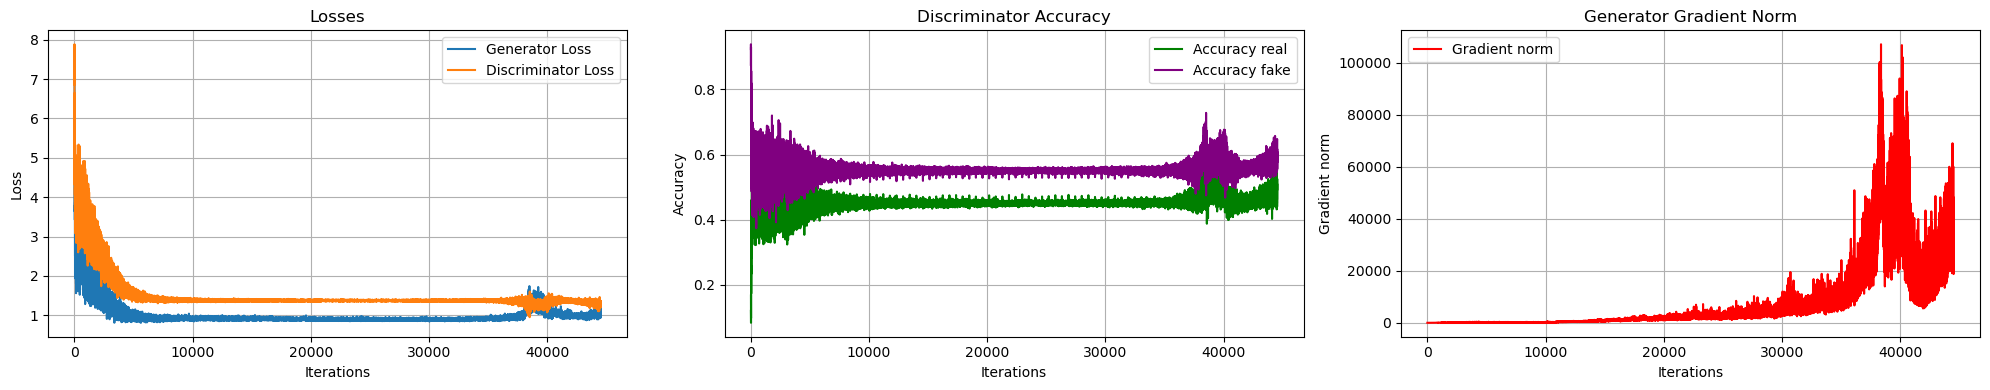

Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:13<00:00, 41.74it/s, v_num=676, d_loss=1.250, acc_real=0.553, acc_fake=0.545, g_loss=1.000, grad_norm=1.99e+4]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:13<00:00, 41.66it/s, v_num=676, d_loss=1.250, acc_real=0.553, acc_fake=0.545, g_loss=1.000, grad_norm=1.99e+4]


In [6]:
trainer.fit(model, datamodule)

## Plot results

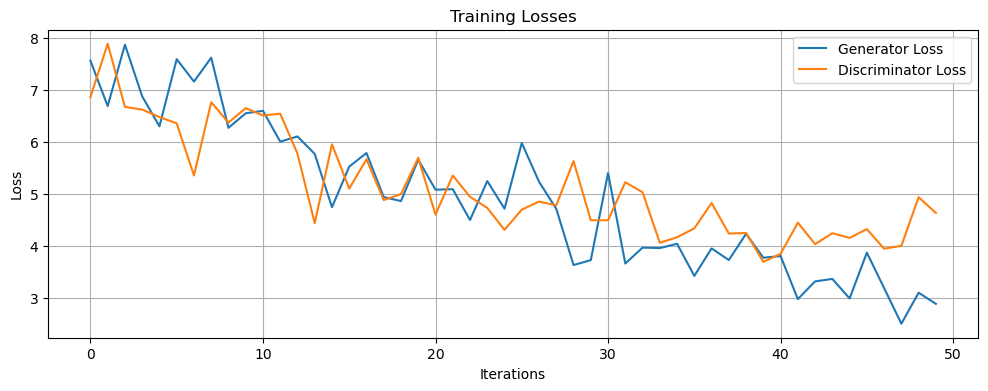

In [7]:
# Plot generator and discriminator losses.
plt.figure(figsize=(12, 4))
plt.plot(loss_tracker.g_losses[:50], label="Generator Loss")
plt.plot(loss_tracker.d_losses[:50], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.savefig("losses.pdf")

In [8]:
len(loss_tracker.g_losses)

44800

## Testing

In [9]:
# Define the dataset.
dataset = MaestroV3DataSet(DATASET_PATH, mode="pair")

# Random index.
rnd_idx = random.randint(0, len(dataset))

# Choose the first random sample from the dataset.
bar_0, _ = dataset[rnd_idx] # [1, 128, 16]
bar_0 = bar_0.unsqueeze(0)
print(bar_0.shape)

torch.Size([1, 1, 128, 16])


In [10]:
# Set model in evaluation.
model.eval()

# Generate noise.
noise = torch.randn(7, 1, 100)

#for z in noise:
#    print(z.shape)

# Generate 8 bar.
bars = [bar_0]
for i, z in enumerate(noise):
    # Previous bar.
    prev = bars[i-1]

    # Create the pair.
    x = z, prev

    # Generate current bar.
    curr = model(x)

    # Save genjerated bar
    bars.append(curr)

In [11]:
# Convert bars in numpy array.
bars_numpy = []
for bar in bars:
    bar = bar.squeeze(0, 1).detach().numpy()
    #print(bar.shape)
    bars_numpy.append(bar)

Bar 0


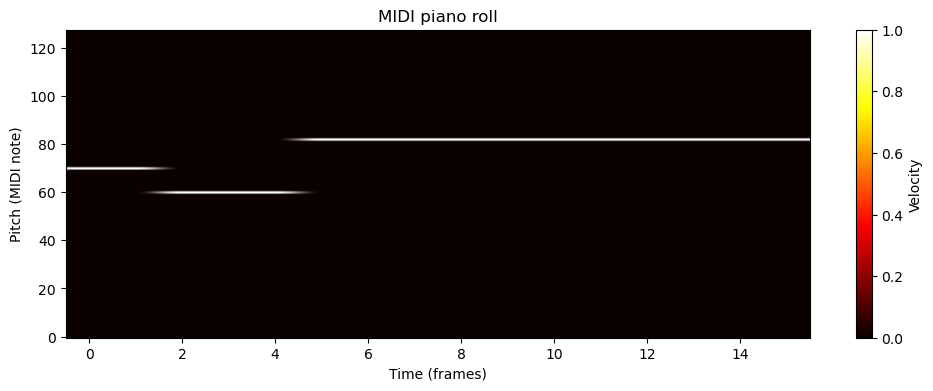

Bar 1


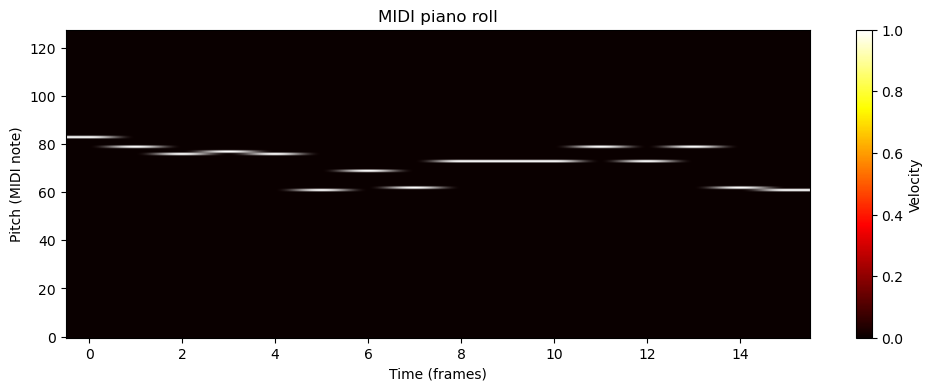

Bar 2


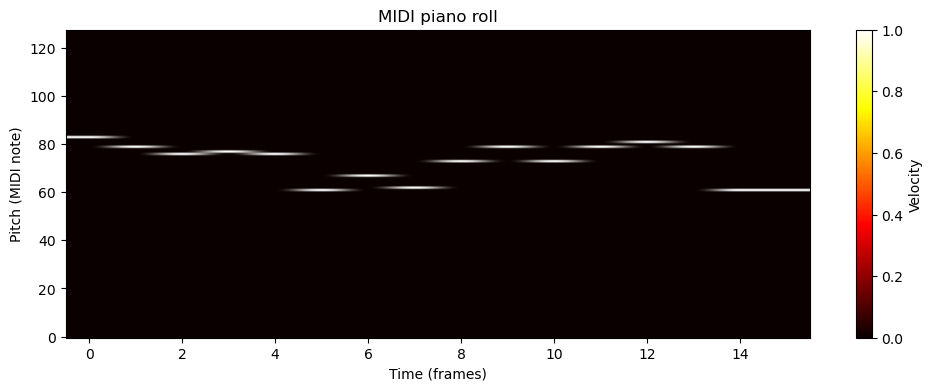

Bar 3


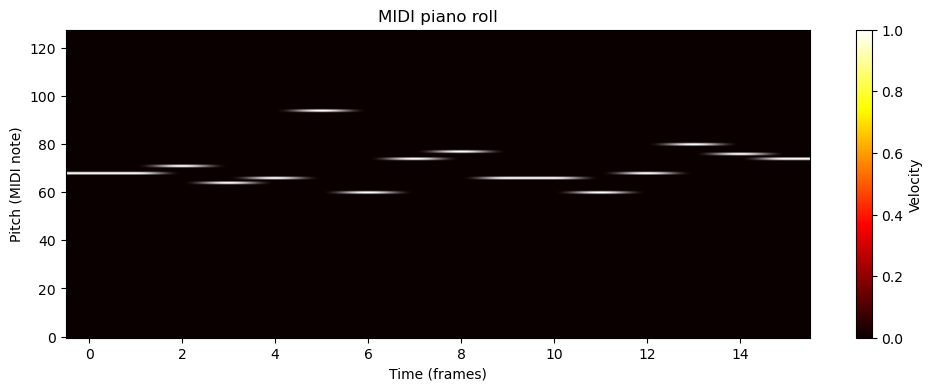

Bar 4


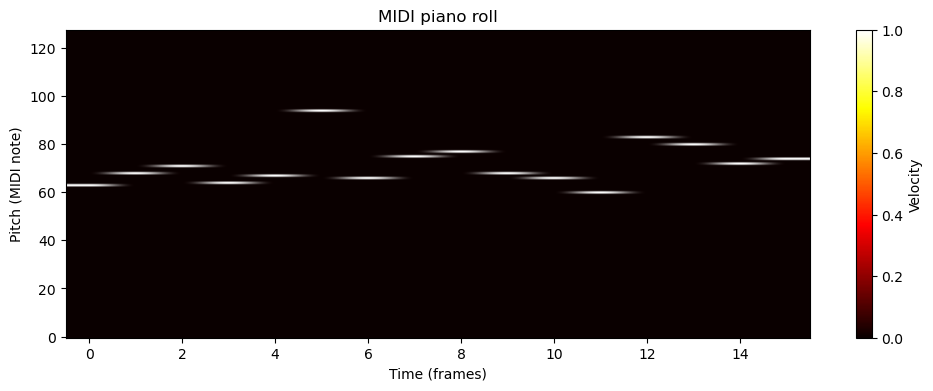

Bar 5


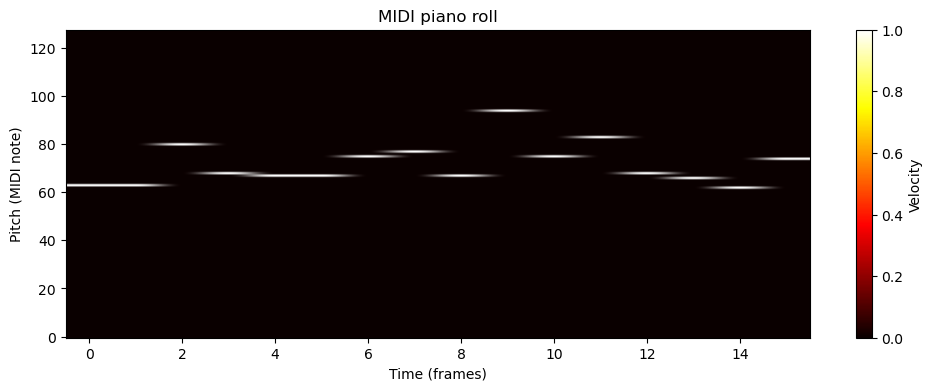

Bar 6


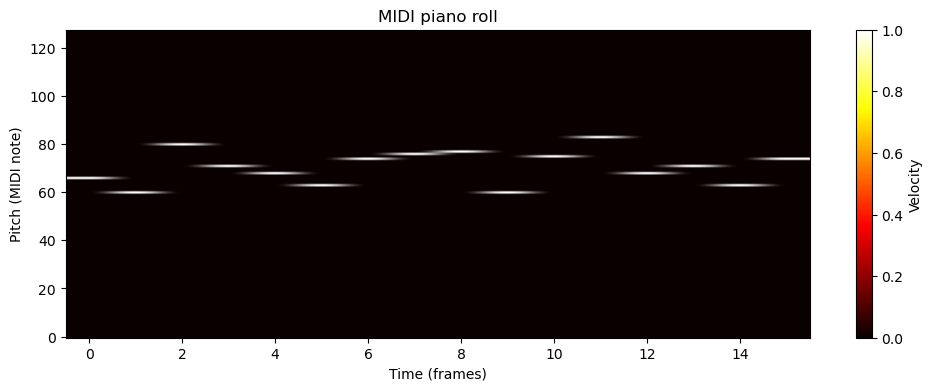

Bar 7


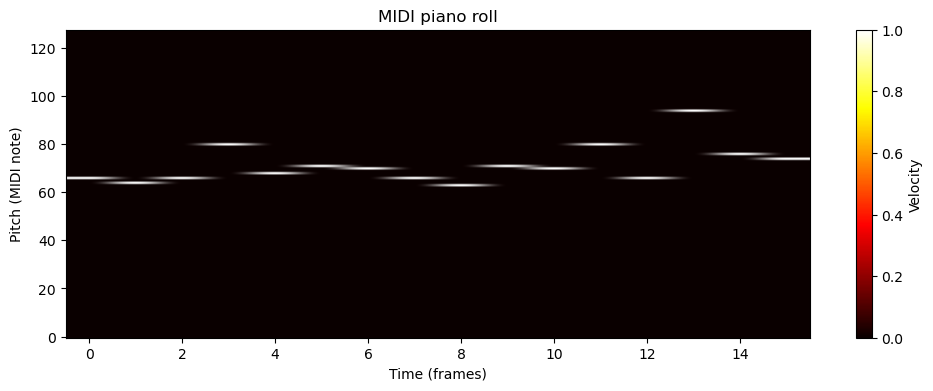

In [12]:
# Plot each single bar.
for i, bar in enumerate(bars_numpy):
    print("Bar", i)
    show_piano_roll(bar)

Full piano roll
Shape: (128, 128)


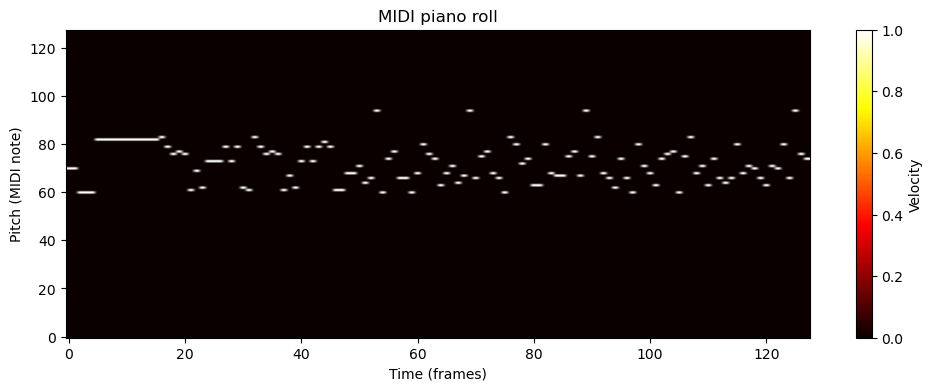

In [13]:
# Create the full piano roll.
full_piano_roll = np.hstack([bar for bar in bars_numpy])
print("Full piano roll")
print("Shape:", full_piano_roll.shape)
show_piano_roll(full_piano_roll)

# Multiply by 50.
full_piano_roll *= 50

In [14]:
# Create the output midi file.
pm = piano_roll_to_pretty_midi(full_piano_roll, fs=8)
output_fn = "output_test.midi"
pm.write(output_fn)